# Librerías

In [97]:
import h5py
import networkx as nx
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, Birch, KMeans
from sklearn.datasets import make_blobs 
from sklearn.model_selection import GridSearchCV
from scipy.spatial.distance import euclidean
from sklearn.neighbors import kneighbors_graph
from scipy.optimize import linear_sum_assignment as linear_assignment

In [98]:
def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size

    y_true = y_true - 1

    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_assignment(w.max() - w)
    dict_ind = {}

    df_cm = pd.DataFrame(w, index = [i for i in range(D)], columns = [i for i in range(D)])

    w_order = np.zeros((D, D), dtype=np.int64)
    for i in range(D):
        for j in range(D):
            w_order[i,j] = w[i, ind[1][j]]

    #df_cm = pd.DataFrame(w_order, index = [i for i in range(D)], columns = [i for i in ind[1]])
    #plt.figure(figsize = (10,7))
    #sns.heatmap(df_cm, annot=True, fmt='g')
    #plt.ylabel("Prediction")
    #plt.xlabel("Ground Truth")

    return sum([w[i, j] for i, j in zip(ind[0], ind[1])]) * 1.0 / y_pred.size

# Ejemplo DBSCAN

In [99]:
# Generar datos de ejemplo
X, _ = make_blobs(n_samples=300, centers=3, random_state=42)

# Crear el objeto DBSCAN
dbscan = DBSCAN(eps=0.9, min_samples=5)

# Realizar el clustering
labels = dbscan.fit_predict(X)

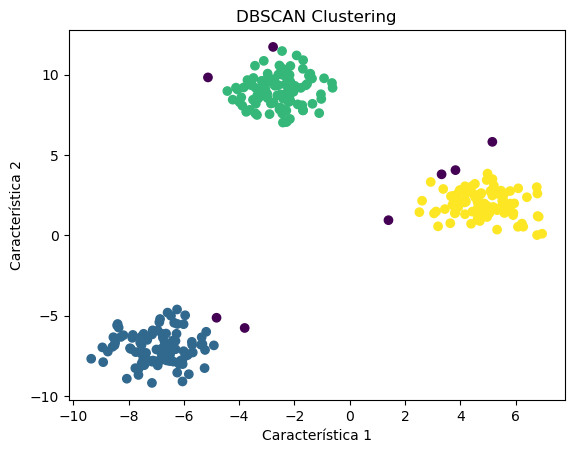

In [100]:
# Visualizar los resultados
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.show()

# DBSCAN en espacio latente

In [101]:
z = pd.read_csv('latentVectors/Z_10PBMC.csv').drop('Unnamed: 0', axis = 1)
z = z.values

In [102]:
data10x = h5py.File('../Tests-GMM/data/Small_Datasets/' + '10X_PBMC_select_2100_top2000.h5')
x = np.array(data10x['X'])
y = np.array(data10x['Y'])

In [103]:
# Crear el objeto DBSCAN
eps_possible = np.linspace(0.01,100,100)
min_samples_possible = [5*i for i in range(1,10)]

In [104]:
max_acc = 0
max_acc_e_m = 0,0

for e in eps_possible:
    for m in min_samples_possible:
        dbscan = DBSCAN(eps=e, min_samples=m)

        # Realizar el clustering
        labels = dbscan.fit_predict(z)
        acc = cluster_acc(y, labels)
        
        if acc > max_acc: 
            max_acc = acc
            max_acc_e_m = e, m
print('Maximos valores: ', max_acc_e_m, max_acc)

Maximos valores:  (2.03, 20) 0.700952380952381


# KNN Graph

In [113]:
# Define the number of neighbors (K) for the KNN graph
K = 5

# Compute pairwise distances between points (can use other distance metrics as well)
distances = np.array([[euclidean(x1, x2) for x2 in z] for x1 in z])

# Create the KNN graph
knn_graph = kneighbors_graph(z, K, mode='connectivity', metric='euclidean')

In [114]:
len(knn_graph.nonzero()[0]) / knn_graph.shape[0]**2 * 100

0.2380952380952381

<AxesSubplot: >

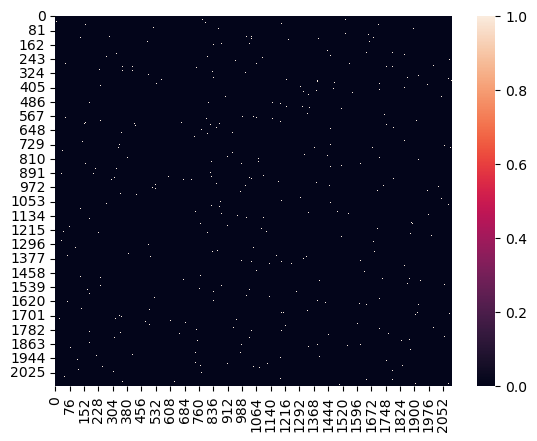

In [115]:
sns.heatmap(knn_graph.todense())

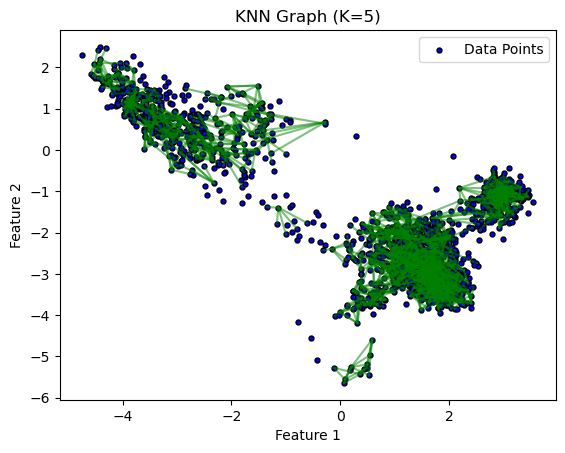

In [116]:
# Plot the data points
plt.scatter(z[:, 0], z[:, 1], c='b', marker='.', edgecolors='k', s=50, label='Data Points')

# Plot the KNN graph connections
for i in range(len(X)):
    for j in knn_graph.indices[knn_graph.indptr[i]:knn_graph.indptr[i + 1]]:
        plt.plot([z[i, 0], z[j, 0]], [z[i, 1], z[j, 1]], c='g', alpha=0.5)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title(f'KNN Graph (K={K})')
plt.legend()
plt.show()


In [117]:
G = nx.Graph(knn_graph)

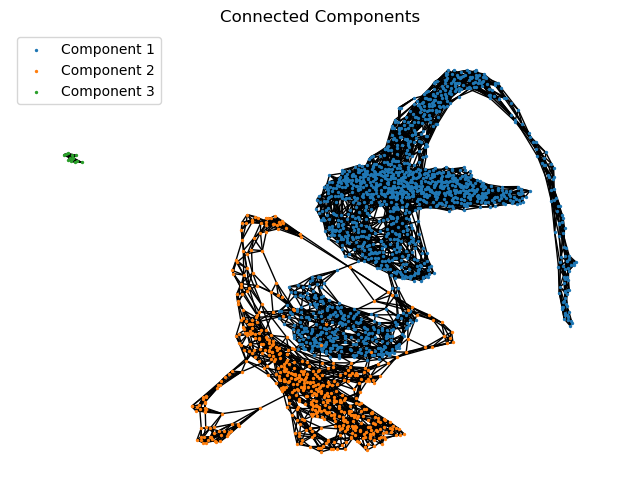

In [129]:
# Find the connected components
connected_components = list(nx.connected_components(G))

# Create a mapping of nodes to their respective connected component index
component_mapping = {}
for i, component in enumerate(connected_components):
    for node in component:
        component_mapping[node] = i

# Generate colors for each connected component
num_components = len(connected_components)
color_map = [f"C{i}" for i in range(num_components)]

# Draw the graph with connected components colored differently
pos = nx.fruchterman_reingold_layout(G)
plt.figure(figsize=(8, 6))
for i in range(num_components):
    nodes = [node for node in G.nodes() if component_mapping[node] == i]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color_map[i], node_size=2, label=f"Component {i+1}")
nx.draw_networkx_edges(G, pos)
plt.legend()
plt.title("Connected Components")
plt.axis("off")
plt.show()

In [138]:
lables = []
s = pd.Series()
for k, nodes in enumerate(connected_components):
    for n in nodes:
        s.loc[n] = k
labels = s.sort_index().values 

acc = cluster_acc(y, labels)
acc

C:\Users\melir\AppData\Local\Temp\ipykernel_11220\1261695439.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()


0.4704761904761905

# BIRCH 

In [109]:
# Define los hiperparámetros a ajustar
param_grid = {
    'threshold': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0],  # Ajusta los valores según sea necesario
    'branching_factor': [10, 50, 100, 150],  # Ajusta los valores según sea necesario
}

max_acc = 0
params = 0, 0 
for t in param_grid['threshold']:
    for b in param_grid['branching_factor']:
        birch_model = Birch(n_clusters=8, threshold = t, branching_factor = b)
        birch_model.fit(z)

        labels = birch_model.predict(z)

        acc = cluster_acc(y, labels)
        if acc > max_acc:
            max_acc = acc
            params = t, b 

print(f'Mejor modelo: {params}. Acc: {max_acc}.')

Mejor modelo: (1.0, 10). Acc: 0.8438095238095238.


c:\Users\melir\anaconda3\envs\env_scRNA\lib\site-packages\sklearn\cluster\_birch.py:726: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (8). Decrease the threshold.
  warnings.warn(
c:\Users\melir\anaconda3\envs\env_scRNA\lib\site-packages\sklearn\cluster\_birch.py:726: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (8). Decrease the threshold.
  warnings.warn(
c:\Users\melir\anaconda3\envs\env_scRNA\lib\site-packages\sklearn\cluster\_birch.py:726: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (8). Decrease the threshold.
  warnings.warn(
c:\Users\melir\anaconda3\envs\env_scRNA\lib\site-packages\sklearn\cluster\_birch.py:726: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (8). Decrease the threshold.
  warnings.warn(


# KMeans 

In [110]:
kmeans_model = KMeans(n_clusters=8)
kmeans_model.fit(z)
labels = kmeans_model.predict(z)

acc = cluster_acc(y, labels)
acc

c:\Users\melir\anaconda3\envs\env_scRNA\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.7747619047619048

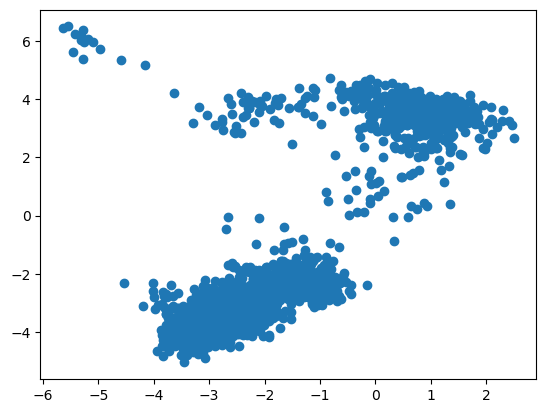

In [111]:
plt.scatter(z[:,1], z[:,2])